# Setup

In [44]:
# import packages
%run ../../global_packages.py

# get the global parameters
%run ../../global_pars.py

# import your local functions
sys.path.insert(1, '../../')
from global_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

# Parameters and Paths

In [45]:
outfn = 'dmi_processed.nc'


In [46]:
# get data from 1958-1999

dmi_ds_1958_1999 = pd.read_csv('dmi_03_01_1958_to_10_01_1999.csv')
dmi_ds_1958_1999 = dmi_ds_1958_1999.to_xarray()

# convert year and month to date time
x = []
for ii in range(len(dmi_ds_1958_1999.year)):
    x.append(dt.date(dmi_ds_1958_1999.year[ii],dmi_ds_1958_1999.month[ii],1))

dmi_ds_1958_1999['dmi'] = xr.DataArray(dmi_ds_1958_1999.dmi,dims = ['time'],coords =[pd.to_datetime(x)])
dmi_ds_1958_1999

<xarray.Dataset>
Dimensions:  (index: 500, time: 500)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * time     (time) datetime64[ns] 1958-03-01 1958-04-01 ... 1999-10-01
Data variables:
    year     (index) int64 1958 1958 1958 1958 1958 ... 1999 1999 1999 1999 1999
    month    (index) int64 3 4 5 6 7 8 9 10 11 12 1 ... 12 1 2 3 4 5 6 7 8 9 10
    dmi      (time) float64 -0.1807 -0.4911 -0.9176 -1.16 ... 1.401 1.567 1.342

In [47]:
# get data from 1981-2020
dmi_ds_1981_2020 = xr.open_dataset('dmi_NOAA_11_04_1981_to_09_23_2020.nc')
dmi_ds_1981_2020

<xarray.Dataset>
Dimensions:  (WEDCEN2: 2030)
Coordinates:
  * WEDCEN2  (WEDCEN2) datetime64[ns] 1981-11-04 1981-11-11 ... 2020-09-23
Data variables:
    DMI      (WEDCEN2) float64 ...
Attributes:
    history:      FERRET V7.3 (optimized)  7-Oct-20
    Conventions:  CF-1.6

In [48]:
dmi_ds_1981_2020

<xarray.Dataset>
Dimensions:  (WEDCEN2: 2030)
Coordinates:
  * WEDCEN2  (WEDCEN2) datetime64[ns] 1981-11-04 1981-11-11 ... 2020-09-23
Data variables:
    DMI      (WEDCEN2) float64 ...
Attributes:
    history:      FERRET V7.3 (optimized)  7-Oct-20
    Conventions:  CF-1.6

In [49]:
# take monthly average and make new variable
dmi = dmi_ds_1981_2020.DMI.resample(WEDCEN2 = '1MS').mean(dim = 'WEDCEN2')
dmi_ds_1981_2020['dmi'] = xr.DataArray(dmi,dims = ['time'],coords =[dmi.WEDCEN2])
dmi_ds_1981_2020

<xarray.Dataset>
Dimensions:  (WEDCEN2: 2030, time: 467)
Coordinates:
  * WEDCEN2  (WEDCEN2) datetime64[ns] 1981-11-04 1981-11-11 ... 2020-09-23
  * time     (time) datetime64[ns] 1981-11-01 1981-12-01 ... 2020-09-01
Data variables:
    DMI      (WEDCEN2) float64 ...
    dmi      (time) float64 -0.2765 -0.2063 0.1823 ... 0.2018 -0.4285 -0.2623
Attributes:
    history:      FERRET V7.3 (optimized)  7-Oct-20
    Conventions:  CF-1.6

This paper: https://link.springer.com/article/10.1007/s00382-016-3382-2

Positive IOD = 5 month running average surpasses 0.5C ( 1 sd ) for more than four consecutive months
Negative IOD same but smaller than -0.5C

In [50]:
# normalize to same standard deviation of newer dataset
std_ratio = dmi_ds_1981_2020.dmi.std()/dmi_ds_1958_1999.dmi.std()
dmi_ds_1958_1999['dmi'] = dmi_ds_1958_1999.dmi * std_ratio


Text(0.5, 1.0, 'raw DMI datasets')

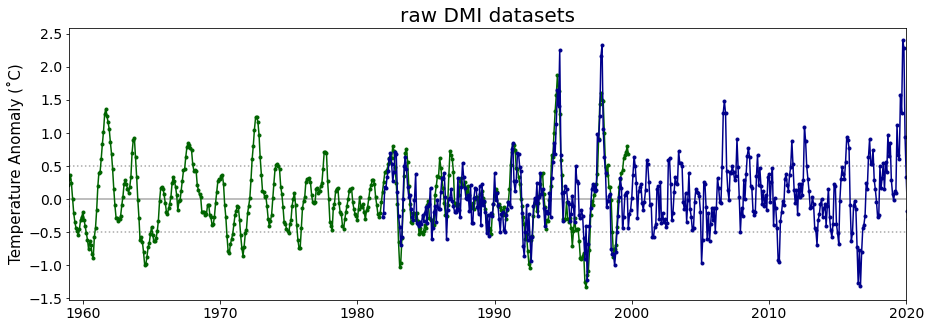

In [51]:
# plot before combinging into one
fig = plt.figure(figsize=(15, 5))
plt.axhline(y=0, color='darkgray', linestyle='-')
plt.axhline(y=0.5, color='darkgray', linestyle=':')
plt.axhline(y=-0.5, color='darkgray', linestyle=':')
old = plt.plot(dmi_ds_1958_1999.time,dmi_ds_1958_1999.dmi, marker = '.',color='darkgreen', label="Positive IOD")
new = plt.plot(dmi_ds_1981_2020.dmi.time,dmi_ds_1981_2020.dmi, marker = '.', color='darkblue',label = 'Negative IOD')
plt.xlim(dt.date(1959,1,1),dt.date(2020,1,1))
plt.ylabel('Temperature Anomaly (˚C)')
plt.title('raw DMI datasets')

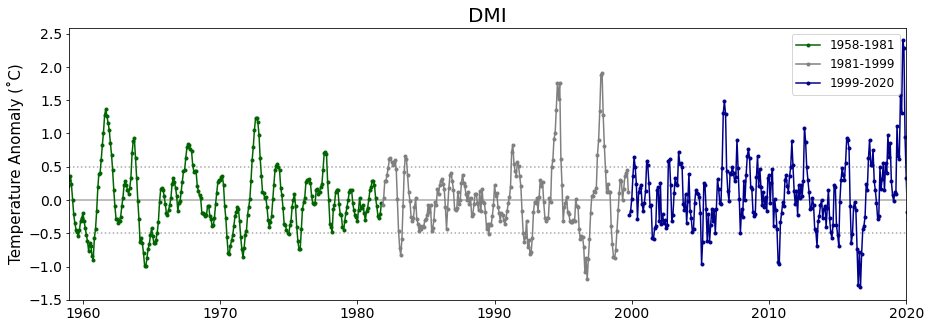

In [52]:
# take average of the two datasets when there is overlap
early = dmi_ds_1958_1999.dmi[dmi_ds_1958_1999.time < dmi_ds_1981_2020.time.min()]
middle = 0.5 *(dmi_ds_1958_1999.dmi[dmi_ds_1958_1999.time >= dmi_ds_1981_2020.time.min()] + 
             dmi_ds_1981_2020.dmi[dmi_ds_1981_2020.time <= dmi_ds_1958_1999.time.max()])
late = dmi_ds_1981_2020.dmi[dmi_ds_1981_2020.time > dmi_ds_1958_1999.time.max()]

# combine
dmi_total = np.concatenate([early, middle, late])
time_total = np.concatenate([early.time, middle.time, late.time])

# add to datset
dmi_ds = xr.Dataset(coords={'time': time_total})
dmi_ds['dmi'] = xr.DataArray(dmi_total,dims = ['time'],coords =[time_total])


# plot before combinging into one
fig = plt.figure(figsize=(15, 5))
plt.axhline(y=0, color='darkgray', linestyle='-')
plt.axhline(y=dmi_ds.dmi.std(), color='darkgray', linestyle=':')
plt.axhline(y=-dmi_ds.dmi.std(), color='darkgray', linestyle=':')
e = plt.plot(early.time,early, marker = '.',color='darkgreen', label="1958-1981")
m = plt.plot(middle.time,middle, marker = '.', color='gray',label = '1981-1999')
l = plt.plot(late.time,late, marker = '.', color='darkblue',label = '1999-2020')
plt.xlim(dt.date(1959,1,1),dt.date(2020,1,1))
plt.ylabel('Temperature Anomaly (˚C)')
plt.title('DMI')
plt.legend()


In [53]:
dmi_total

array([-9.17693050e-02, -2.49335892e-01, -4.65920388e-01, -5.89062061e-01,
       -7.21572591e-01, -8.13301277e-01, -7.00506372e-01, -4.65884846e-01,
       -1.14541030e-01,  2.11951857e-01,  2.93565813e-01,  3.54375544e-01,
        2.34384410e-01, -5.17896930e-03, -2.16828720e-01, -3.51192001e-01,
       -4.44039750e-01, -4.87327810e-01, -5.46889003e-01, -4.50049386e-01,
       -3.13971460e-01, -2.68363019e-01, -2.01464444e-01, -3.19491632e-01,
       -4.15273622e-01, -5.22436144e-01, -6.19526586e-01, -7.65121630e-01,
       -6.45055858e-01, -6.92352034e-01, -8.39272285e-01, -8.95296547e-01,
       -5.72611217e-01, -4.36984166e-01, -1.65844306e-01,  1.87633550e-01,
        3.96871526e-01,  4.00344989e-01,  5.98455290e-01,  8.28274591e-01,
        1.01384925e+00,  1.27747402e+00,  1.36535909e+00,  1.25788533e+00,
        1.15941383e+00,  1.05728151e+00,  8.55646967e-01,  6.78094636e-01,
        4.52095079e-01,  1.52668907e-01, -9.42536871e-02, -2.84073574e-01,
       -2.91478485e-01, -

In [54]:
time_total

array(['1958-03-01T00:00:00.000000000', '1958-04-01T00:00:00.000000000',
       '1958-05-01T00:00:00.000000000', '1958-06-01T00:00:00.000000000',
       '1958-07-01T00:00:00.000000000', '1958-08-01T00:00:00.000000000',
       '1958-09-01T00:00:00.000000000', '1958-10-01T00:00:00.000000000',
       '1958-11-01T00:00:00.000000000', '1958-12-01T00:00:00.000000000',
       '1959-01-01T00:00:00.000000000', '1959-02-01T00:00:00.000000000',
       '1959-03-01T00:00:00.000000000', '1959-04-01T00:00:00.000000000',
       '1959-05-01T00:00:00.000000000', '1959-06-01T00:00:00.000000000',
       '1959-07-01T00:00:00.000000000', '1959-08-01T00:00:00.000000000',
       '1959-09-01T00:00:00.000000000', '1959-10-01T00:00:00.000000000',
       '1959-11-01T00:00:00.000000000', '1959-12-01T00:00:00.000000000',
       '1960-01-01T00:00:00.000000000', '1960-02-01T00:00:00.000000000',
       '1960-03-01T00:00:00.000000000', '1960-04-01T00:00:00.000000000',
       '1960-05-01T00:00:00.000000000', '1960-06-01

Text(0.5, 1.0, '3 Month Running Mean of DMI')

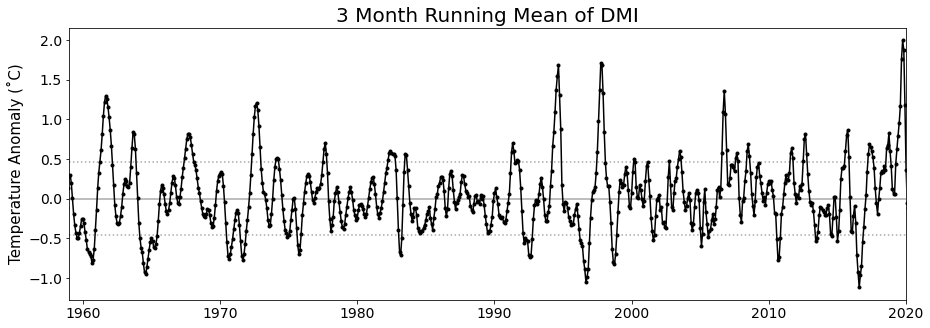

In [55]:
dmi_ds['dmi_3mo_runmean'] = dmi_ds.dmi.rolling(time=3, center=True).mean()

# plot before combinging into one
fig = plt.figure(figsize=(15, 5))
plt.axhline(y=0, color='darkgray', linestyle='-')
plt.axhline(y=dmi_ds.dmi_3mo_runmean.std(), color='darkgray', linestyle=':')
plt.axhline(y=-dmi_ds.dmi_3mo_runmean.std(), color='darkgray', linestyle=':')
plt.plot(dmi_ds.time,dmi_ds.dmi_3mo_runmean, marker = '.',color='k')
plt.xlim(dt.date(1959,1,1),dt.date(2020,1,1))
plt.ylabel('Temperature Anomaly (˚C)')
plt.title('3 Month Running Mean of DMI')

In [56]:
# get std
st_dev = np.array(dmi_ds.dmi_3mo_runmean.std())


# find pos iod years when > 1 std for mean SON and
# neg iod years when < -1 std for mean SON
pos_IOD_years = []
neg_IOD_years = []
neu_IOD_years = []

spos_IOD_years = []
sneg_IOD_years = []

wpos_IOD_years = []
wneg_IOD_years = []

for yy,year in enumerate(np.unique(dmi_ds.time.dt.year)):
  
    start_time = str(year) + '-09-01' #sept - nov average
    end_time = str(year) + '-11-30'
    time_slice = slice(start_time, end_time)
    data = dmi_ds.dmi_3mo_runmean.sel(time=time_slice)
    
    if np.nanmean(data) >= st_dev:
        pos_IOD_years.append(year)
        
        # find strong pos IOD years
        if np.nanmean(data) >= 2*st_dev:
            spos_IOD_years.append(year)
        else:
            wpos_IOD_years.append(year)
            
    elif np.nanmean(data) <= -st_dev:
        neg_IOD_years.append(year)  
        
        # find strong neg IOD years
        if np.nanmean(data) <= -1.5*st_dev:
            sneg_IOD_years.append(year)
        else:
            wneg_IOD_years.append(year)
    else:
        neu_IOD_years.append(year)
            
    
dmi_ds['pos_IOD_years'] = xr.DataArray(np.unique(pos_IOD_years),dims = ['posyears'],coords =[np.unique(pos_IOD_years)])
dmi_ds['neg_IOD_years'] = xr.DataArray(np.unique(neg_IOD_years),dims = ['negyears'],coords =[np.unique(neg_IOD_years)])
dmi_ds['neu_IOD_years'] = xr.DataArray(np.unique(neu_IOD_years),dims = ['neuyears'],coords =[np.unique(neu_IOD_years)])

dmi_ds['spos_IOD_years'] = xr.DataArray(np.unique(spos_IOD_years),dims = ['sposyears'],coords =[np.unique(spos_IOD_years)])
dmi_ds['sneg_IOD_years'] = xr.DataArray(np.unique(sneg_IOD_years),dims = ['snegyears'],coords =[np.unique(sneg_IOD_years)])

dmi_ds['wpos_IOD_years'] = xr.DataArray(np.unique(wpos_IOD_years),dims = ['wposyears'],coords =[np.unique(wpos_IOD_years)])
dmi_ds['wneg_IOD_years'] = xr.DataArray(np.unique(wneg_IOD_years),dims = ['wnegyears'],coords =[np.unique(wneg_IOD_years)])

dmi_ds['std'] = xr.DataArray(st_dev)



/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice


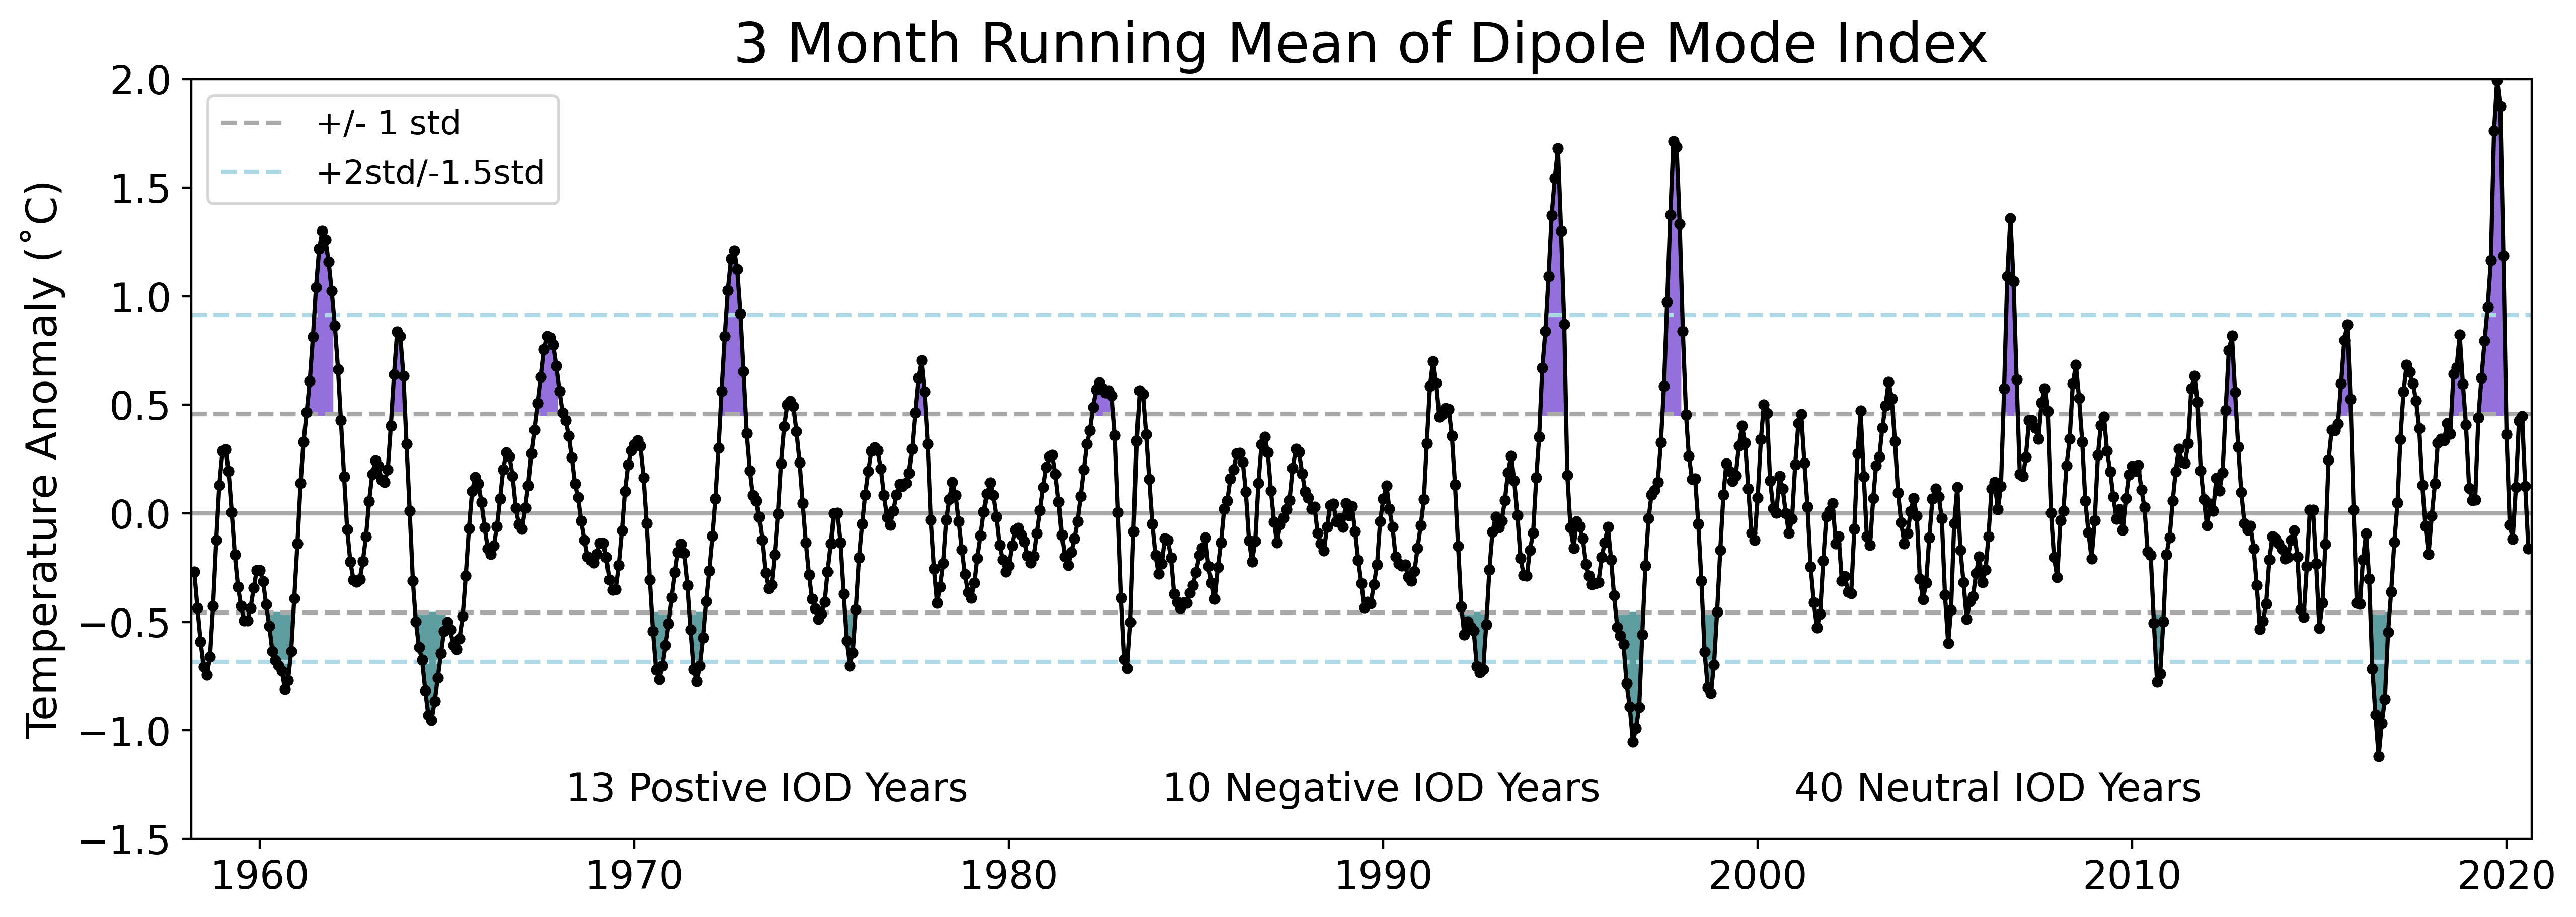

In [66]:
# plot before combinging into one

params = {'legend.fontsize': 12,
         'axes.labelsize': 15,
         'axes.titlesize': 20,
         'xtick.labelsize':14,
         'ytick.labelsize':14}

pylab.rcParams.update(params)

fig = plt.figure(figsize=(15, 5), dpi = 400)
plt.axhline(y=0, color='darkgray', linestyle='-')
std1 = plt.axhline(y=dmi_ds.dmi_3mo_runmean.std(), color='darkgray', linestyle='--')
plt.axhline(y=-dmi_ds.dmi_3mo_runmean.std(), color='darkgray', linestyle='--')
std2 = plt.axhline(y=dmi_ds.dmi_3mo_runmean.std()*2, color='lightblue', linestyle='--')
plt.axhline(y=-dmi_ds.dmi_3mo_runmean.std()*1.5, color='lightblue', linestyle='--')
plt.plot(dmi_ds.time,dmi_ds.dmi_3mo_runmean, marker = '.',color='k')
for posyear in pos_IOD_years:
    
    ind = dmi_ds.time.dt.year == posyear
    x = np.array(dmi_ds.time[ind])
    y2 = st_dev
    y1 = np.array(dmi_ds.dmi_3mo_runmean[ind])
    
    plt.fill_between(x,y1,y2,where=y1 > y2,color = 'mediumpurple')
    
for negyear in neg_IOD_years:
    
    ind = dmi_ds.time.dt.year == negyear
    x = np.array(dmi_ds.time[ind])
    y1 = -st_dev
    y2 = np.array(dmi_ds.dmi_3mo_runmean[ind])
    
    plt.fill_between(x,y1,y2,where=y1 > y2,color = 'cadetblue')
add_text(plt.gca(), str(len(dmi_ds.posyears)) + ' Postive IOD Years', x = 0.16,y=0.05, fontsize = 14)
add_text(plt.gca(), str(len(dmi_ds.negyears)) + ' Negative IOD Years', x = 0.415,y=0.05, fontsize = 14)
add_text(plt.gca(), str(len(dmi_ds.neuyears)) + ' Neutral IOD Years', x = 0.685,y=0.05, fontsize = 14)
plt.xlim(dt.date(1958,3,1),dt.date(2020,9,1))
plt.ylim([-1.5,2])
plt.ylabel('Temperature Anomaly (˚C)')
plt.title('3 Month Running Mean of Dipole Mode Index')

l = plt.legend([std1,std2],['+/- 1 std', '+2std/-1.5std'],facecolor = 'w', loc = 'upper left')


In [59]:
# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)
    
dmi_ds.to_netcdf(outfn,mode='w',format = "NETCDF4")
dmi_ds

<xarray.Dataset>
Dimensions:          (negyears: 10, neuyears: 40, posyears: 13, snegyears: 6, sposyears: 6, time: 751, wnegyears: 4, wposyears: 7)
Coordinates:
  * time             (time) datetime64[ns] 1958-03-01 1958-04-01 ... 2020-09-01
  * posyears         (posyears) int64 1961 1963 1967 1972 ... 2015 2018 2019
  * negyears         (negyears) int64 1960 1964 1970 1971 ... 1998 2010 2016
  * neuyears         (neuyears) int64 1958 1959 1962 1965 ... 2014 2017 2020
  * sposyears        (sposyears) int64 1961 1972 1994 1997 2006 2019
  * snegyears        (snegyears) int64 1960 1964 1970 1996 1998 2016
  * wposyears        (wposyears) int64 1963 1967 1977 1982 2012 2015 2018
  * wnegyears        (wnegyears) int64 1971 1975 1992 2010
Data variables:
    dmi              (time) float64 -0.09177 -0.2493 -0.4659 ... -0.4285 -0.2623
    dmi_3mo_runmean  (time) float64 nan -0.269 -0.4348 ... 0.1261 -0.163 nan
    pos_IOD_years    (posyears) int64 1961 1963 1967 1972 ... 2015 2018 2019
    ne

In [60]:
dmi_ds.posyears

<xarray.DataArray 'posyears' (posyears: 13)>
array([1961, 1963, 1967, 1972, 1977, 1982, 1994, 1997, 2006, 2012, 2015, 2018,
       2019])
Coordinates:
  * posyears  (posyears) int64 1961 1963 1967 1972 1977 ... 2012 2015 2018 2019

In [61]:
dmi_ds.negyears

<xarray.DataArray 'negyears' (negyears: 10)>
array([1960, 1964, 1970, 1971, 1975, 1992, 1996, 1998, 2010, 2016])
Coordinates:
  * negyears  (negyears) int64 1960 1964 1970 1971 1975 1992 1996 1998 2010 2016

In [62]:
dmi_ds.sposyears

<xarray.DataArray 'sposyears' (sposyears: 6)>
array([1961, 1972, 1994, 1997, 2006, 2019])
Coordinates:
  * sposyears  (sposyears) int64 1961 1972 1994 1997 2006 2019